# Train Ulmo with llc modis-2012 data

In [1]:
import numpy as np
from ulmo.models import DCAE, ConditionalFlow
from ulmo.ood import ProbabilisticAutoencoder

In [2]:
import h5py

## Split the data set into 'train' and 'valid' part

In [3]:
filepath = '/home/jovyan/ulmo/ulmo/runs/LLC/experiments/datasets/llc_modis_2012/LLC_modis2012_test_preproc.h5'

In [6]:
with h5py.File(filepath, 'r') as f:
    print(f.keys())
    len_valid = f['valid'].shape[0]
    print(len_valid)
    modis_2012 = f['valid'][:]

<KeysViewHDF5 ['valid', 'valid_metadata']>
635295


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

In [8]:
 modis_2012_train, modis_2012_test = train_test_split(
     modis_2012, test_size=0.1, random_state=0)

## Create new h5py file with train and valid

In [3]:
filepath_split = '/home/jovyan/ulmo/ulmo/runs/LLC/experiments/datasets/llc_modis_2012/LLC_modis2012_test_preproc_split.h5'

In [11]:
with h5py.File(filepath_split, 'w') as f:
    f.create_dataset('train', data=modis_2012_train)
    f.create_dataset('valid', data=modis_2012_test)

## Train Autoencoder

In [4]:
autoencoder = DCAE(image_shape=(1, 64, 64), latent_dim=512)

In [5]:
flow = ConditionalFlow(
    dim=512, 
    context_dim=None, 
    transform_type='autoregressive', 
    n_layers=10, 
    hidden_units=256,
    n_blocks=2, 
    dropout=0.2, 
    use_batch_norm=False, 
    tails='linear', 
    tail_bound=10, 
    n_bins=5,
    min_bin_height=1e-3, 
    min_bin_width=1e-3, 
    min_derivative=1e-3, 
    unconditional_transform=False, 
    encoder=None)

In [6]:
pae = ProbabilisticAutoencoder(autoencoder=autoencoder, flow=flow, filepath=filepath_split)

Using device=cuda
Wrote model parameters to ./model.json


## Train Autoencoder

571,648 training samples. 63,488 validation samples.


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/2233 [00:14<?, ?batch/s]

  0%|          | 0/2233 [00:14<?, ?batch/s]

  0%|          | 0/2233 [00:14<?, ?batch/s]

  0%|          | 0/2233 [00:15<?, ?batch/s]

  0%|          | 0/2233 [00:14<?, ?batch/s]

Training stopped. Save model (y/n)? y


Model saved.
Loading autoencoder model from: ./autoencoder.pt


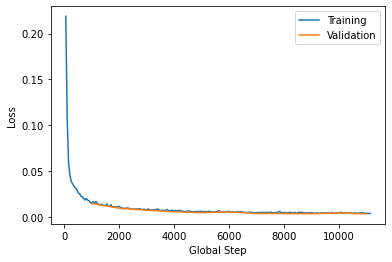

In [15]:
pae.train_autoencoder(n_epochs=5, batch_size=256, lr=2.5e-3, summary_interval=50, eval_interval=1000)

## Train Flow

Existing latents file found. Use file (y) or recompute (n)? y


571,712 training samples. 63,488 validation samples.


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/8933 [00:09<?, ?batch/s]

  0%|          | 0/8933 [00:09<?, ?batch/s]

  0%|          | 0/8933 [00:10<?, ?batch/s]

  0%|          | 0/8933 [00:09<?, ?batch/s]

  0%|          | 0/8933 [00:10<?, ?batch/s]

Training stopped. Save model (y/n)? y


Model saved.
Loading flow model from: ./flow.pt


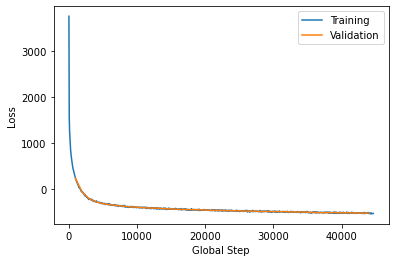

In [7]:
pae.train_flow(n_epochs=5, batch_size=64, lr=2.5e-4, summary_interval=50, eval_interval=1000)

## Histogram of the Evaluation

Existing log probs file found. Use file (y) or recompute (n)? y


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


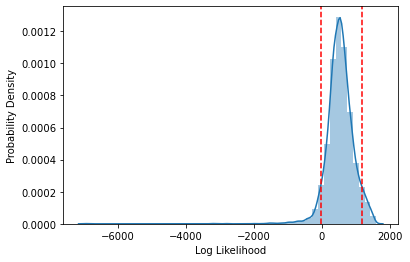

In [7]:
pae.plot_log_probs()